In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from notebook_init_utils import bandicoot_check, init_notebook
from pycytominer import normalize

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
convolutions = list(range(1, 26))
convolutions += [50, 75, 100]
subdir_names = [f"convolution_{i}_image_based_profiles" for i in convolutions]
subdir_names += ["image_based_profiles"]
subdir_names += ["deconvolved_images_image_based_profiles"]

In [3]:
organoid_convolution_paths = [
    pathlib.Path(
        f"{image_base_dir}/data/NF0014_T1/{subdir_name}/2.annotated_profiles/organoid_anno.parquet"
    )
    for subdir_name in subdir_names
]

sc_convolution_paths = [
    pathlib.Path(
        f"{image_base_dir}/data/NF0014_T1/{subdir_name}/2.annotated_profiles/sc_anno.parquet"
    )
    for subdir_name in subdir_names
]

In [4]:
# Merge organoid profiles
organoid_combined_dfs = pd.concat(
    [
        pd.read_parquet(path).assign(
            Metadata_convolution=path.parent.parent.name.replace(
                "_image_based_profiles", ""
            )
        )
        for path in organoid_convolution_paths
    ],
    ignore_index=True,
)
organoid_combined_dfs["Metadata_convolution"] = organoid_combined_dfs[
    "Metadata_convolution"
].replace(
    {
        "image_based_profiles": "0",
        "deconvolved_images": "-1",
        "convolution_": "",
    },
    regex=True,
)
# drop all Metadata_image_sets that are not C4-2
organoid_combined_dfs = organoid_combined_dfs[
    organoid_combined_dfs["Metadata_image_set"] == "C4-2"
]
organoid_combined_dfs.reset_index(drop=True, inplace=True)
organoid_combined_dfs["Metadata_convolution"] = organoid_combined_dfs[
    "Metadata_convolution"
].astype(str)

# merge sc profiles
sc_combined_dfs = pd.concat(
    [
        pd.read_parquet(path).assign(
            Metadata_convolution=path.parent.parent.name.replace(
                "_image_based_profiles", ""
            )
        )
        for path in sc_convolution_paths
    ],
    ignore_index=True,
)
sc_combined_dfs["Metadata_convolution"] = sc_combined_dfs[
    "Metadata_convolution"
].replace(
    {
        "image_based_profiles": "0",
        "deconvolved_images": "-1",
        "convolution_": "",
    },
    regex=True,
)
# drop all Metadata_image_sets that are not C4-2
sc_combined_dfs = sc_combined_dfs[sc_combined_dfs["Metadata_image_set"] == "C4-2"]
sc_combined_dfs.reset_index(drop=True, inplace=True)
sc_combined_dfs["Metadata_convolution"] = sc_combined_dfs[
    "Metadata_convolution"
].astype(str)

In [5]:
organoid_metadata_columns = [
    x for x in organoid_combined_dfs.columns if "Metadata" in x
]

organoid_metadata_columns += [
    "Area.Size.Shape_Organoid_CENTER.X",
    "Area.Size.Shape_Organoid_CENTER.Y",
    "Area.Size.Shape_Organoid_CENTER.Z",
]
organoid_features_columns = [
    col for col in organoid_combined_dfs.columns if col not in organoid_metadata_columns
]

# sc metadata and features
sc_metadata_columns = [x for x in sc_combined_dfs.columns if "Metadata" in x]

sc_metadata_columns += [
    "Area.Size.Shape_Cell_CENTER.X",
    "Area.Size.Shape_Cell_CENTER.Y",
    "Area.Size.Shape_Cell_CENTER.Z",
    "Area.Size.Shape_Nuclei_CENTER.X",
    "Area.Size.Shape_Nuclei_CENTER.Y",
    "Area.Size.Shape_Nuclei_CENTER.Z",
    "Area.Size.Shape_Cytoplasm_CENTER.X",
    "Area.Size.Shape_Cytoplasm_CENTER.Y",
    "Area.Size.Shape_Cytoplasm_CENTER.Z",
]
sc_features_columns = [
    col for col in sc_combined_dfs.columns if col not in sc_metadata_columns
]

In [6]:
# find inf values and replace with NaN
organoid_combined_dfs[organoid_features_columns] = organoid_combined_dfs[
    organoid_features_columns
].replace([float("inf"), -float("inf")], np.nan)

# sc
sc_combined_dfs[sc_features_columns] = sc_combined_dfs[sc_features_columns].replace(
    [float("inf"), -float("inf")], np.nan
)

In [7]:
# normalize the data
organoid_normalized_profiles = normalize(
    organoid_combined_dfs,
    features=organoid_features_columns,
    meta_features=organoid_metadata_columns,
    method="standardize",
    samples="Metadata_convolution == '0'",
)
organoid_normalized_profiles[organoid_normalized_profiles.isna() == True] = 0

# normalize the data sc
sc_normalized_profiles = normalize(
    sc_combined_dfs,
    features=sc_features_columns,
    meta_features=sc_metadata_columns,
    method="standardize",
    samples="Metadata_convolution == '0'",
)
sc_normalized_profiles[sc_normalized_profiles.isna() == True] = 0

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [8]:
# save the normalized profiles
organoid_normalized_output_path = pathlib.Path(
    f"{root_dir}/7.technical_analysis/processed_data/organoid_normalized_convolution_profiles.parquet"
).resolve()
sc_normalized_output_path = pathlib.Path(
    f"{root_dir}/7.technical_analysis/processed_data/sc_normalized_convolution_profiles.parquet"
).resolve()
organoid_normalized_output_path.parent.mkdir(parents=True, exist_ok=True)
organoid_normalized_profiles.to_parquet(organoid_normalized_output_path, index=False)
sc_normalized_output_path.parent.mkdir(parents=True, exist_ok=True)
sc_normalized_profiles.to_parquet(sc_normalized_output_path, index=False)

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


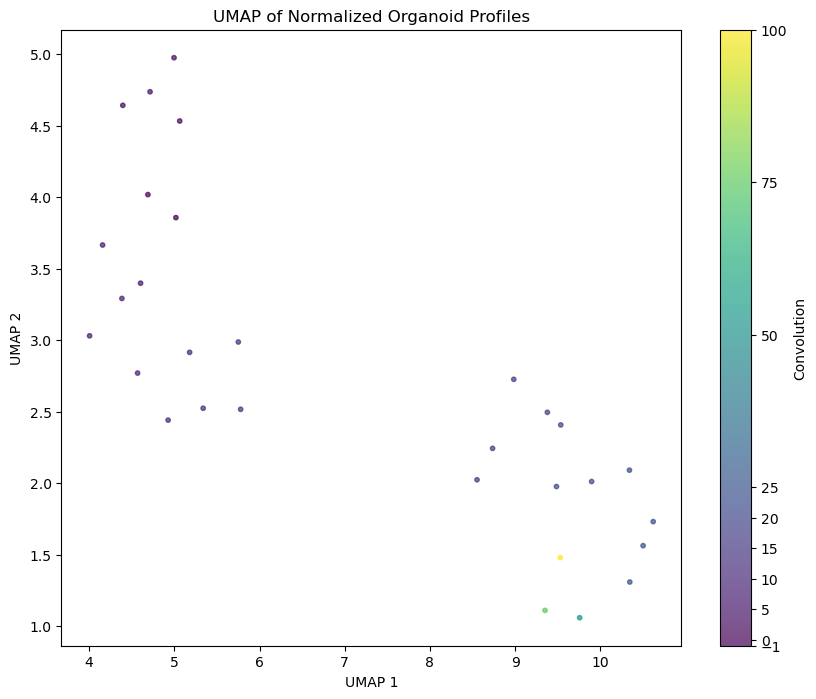

In [9]:
# plot on UMAP (use continuous colorbar from -1 to 25)
import umap

organoid_normalized_profiles["Metadata_convolution"] = organoid_normalized_profiles[
    "Metadata_convolution"
].astype(int)
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(
    organoid_normalized_profiles[organoid_features_columns].values
)

cvals = organoid_normalized_profiles["Metadata_convolution"].astype(float).values
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=cvals,
    cmap="viridis",
    vmin=-1,
    s=10,
    alpha=0.7,
)
cbar = plt.colorbar(sc)
cbar.set_label("Convolution")
cbar.set_ticks([-1, 0, 5, 10, 15, 20, 25, 50, 75, 100])

plt.title("UMAP of Normalized Organoid Profiles")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


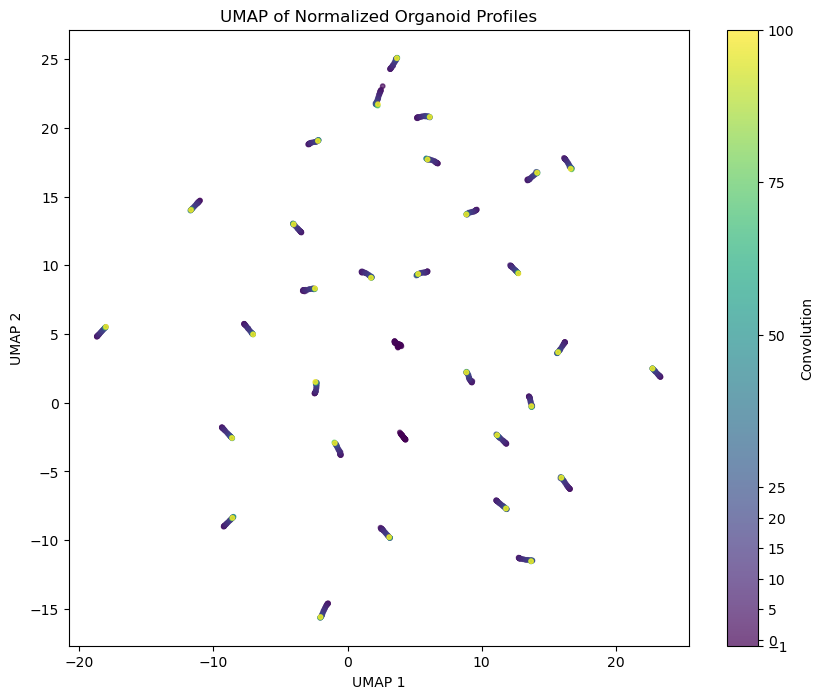

In [10]:
# plot on UMAP (use continuous colorbar from -1 to 25)
import umap

sc_normalized_profiles["Metadata_convolution"] = sc_normalized_profiles[
    "Metadata_convolution"
].astype(int)
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(sc_normalized_profiles[sc_features_columns].values)

cvals = sc_normalized_profiles["Metadata_convolution"].astype(float).values
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=cvals,
    cmap="viridis",
    vmin=-1,
    s=10,
    alpha=0.7,
)
cbar = plt.colorbar(sc)
cbar.set_label("Convolution")
cbar.set_ticks([-1, 0, 5, 10, 15, 20, 25, 50, 75, 100])

plt.title("UMAP of Normalized Organoid Profiles")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()